In [24]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance")
from src.s3 import list_files_in_bucket, filter_files_by_pattern, read_parquet_from_s3
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from src.gtfs_segments import GTFS_shape_processor
from src.speeds import BusSpeedCalculator
from src.api import parse_zipped_gtfs
import geopandas as gpd
from src.api import query_feed_data, get_access_token
ACCESS_TOKEN = get_access_token()
pd.set_option('display.max_columns', None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
prefix = "norm/bus-mta-vp/vehicles/"
bucket = "dataclinic-gtfs-rt"

In [26]:
def load_all_parquet_files(file_list, bucket, max_workers=100):
    dfs = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(read_parquet_from_s3, bucket, key) for key in file_list]
        for future in as_completed(futures):
            try:
                dfs.append(future.result())
            except Exception as e:
                print(f"Error reading a file: {e}")
    return pd.concat(dfs, ignore_index=True)

## Step 0: Figure out which static feed is correct.

Pretty annoying. The trips and shapes are defined in the static gtfs feeds, and everytime a new static feed is released, the old `trip_id` values become obsolete. This is unfortunate because . It should be possible to just load all of the relevant static feeds and run a quick check on the relevant realtime feed data to see which static feed is in correct for the given dates. However, we can also just look through the outputs from MobilityData's API and find the one we want. Below, I load all the feeds for Manhattan.

In [27]:
query_feed_data("mdb-513", ACCESS_TOKEN)
# https://mobilitydatabase.org/feeds/mdb-513

[{'id': 'mdb-513-202402080022',
  'feed_id': 'mdb-513',
  'hosted_url': 'https://files.mobilitydatabase.org/mdb-513/mdb-513-202402080022/mdb-513-202402080022.zip',
  'note': None,
  'downloaded_at': '2024-02-08T00:52:25.481924Z',
  'hash': '25ebc713eff01d5d5da7e6a877926d636152417153dc591ef0763fa0851b3819',
  'bounding_box': {'minimum_latitude': 40.701536,
   'maximum_latitude': 40.865316,
   'minimum_longitude': -74.018088,
   'maximum_longitude': -73.864375},
  'validation_report': None,
  'service_date_range_start': None,
  'service_date_range_end': None},
 {'id': 'mdb-513-202404010033',
  'feed_id': 'mdb-513',
  'hosted_url': 'https://files.mobilitydatabase.org/mdb-513/mdb-513-202404010033/mdb-513-202404010033.zip',
  'note': None,
  'downloaded_at': '2024-04-01T00:26:36.207481Z',
  'hash': '4e9fce8767c4fe3eb5f0529ea49d29270543d0563d7fbf0d8c4c0920b61a3fbf',
  'bounding_box': {'minimum_latitude': 40.701536,
   'maximum_latitude': 40.865316,
   'minimum_longitude': -74.018088,
   'max

Here's the file for early January:

In [28]:
# Choose the correct url based on the date of the static feed
url1 = "https://files.mobilitydatabase.org/mdb-513/mdb-513-202501020055/mdb-513-202501020055.zip"
url2 = "https://files.mobilitydatabase.org/mdb-513/mdb-513-202409090026/mdb-513-202409090026.zip"

# Use Case: Dec 2024 and Jan 2025 Comparison

Roadmap:
1. date
2. route_id
3. url (date -> url)
4. segment_df (route_id + url -> segment_df)

Case 1:
- Bus Route: M50
- Date: Dec 6 2024 and Jan 6 2025
- Time: Aggregated average speed for each hour / half hour
- Plot: Line graph for each date 

Case 2:
- Bus Route: M50
- Date: Dec 2024 and Jan 2025, Thursday only
- Time: Aggregated average speed for each hour / half hour
- Plot: Line graph for each date 


In [33]:
# Step 0: Get the correct static feed and specify the url
bucket = "dataclinic-gtfs-rt"

def calculate_speeds_for_route(bucket, date, route_id, gtfs_url):
    # Step 1: Process static feed shapes into geodataframe
    # get segment_df based on gtfs_url (static feed)
    segment_df = GTFS_shape_processor(gtfs_url, 4326, 2263).process_shapes()

    # Step 2: Load relevant realtime data and calculate speeds
    daily_files = list_files_in_bucket(bucket_name = bucket, prefix = f"{prefix}date={date}/")
    vehicle_positions = load_all_parquet_files(file_list = daily_files, bucket = bucket)
    GTFS_dict = parse_zipped_gtfs(gtfs_url)

    # Step 3: Calculate speeds
    speed_calculator = BusSpeedCalculator(vehicle_positions, GTFS_dict, segment_df)
    speeds = speed_calculator.create_trip_speeds()
    speeds = speed_calculator.match_trip_with_route(speeds)
    
    speeds = speeds[speeds["route_id"] == route_id]
    speeds = speeds[speeds["speed_mph"] < 70]
    return speeds

In [35]:
date1 = "2025-01-06"
route_id = "M50"
url1 = "https://files.mobilitydatabase.org/mdb-513/mdb-513-202501020055/mdb-513-202501020055.zip"
bucket = "dataclinic-gtfs-rt"   
speeds1 = calculate_speeds_for_route(bucket, date1, route_id, url1)
speeds1.to_csv("data/speeds1.csv")
print(speeds1.shape)

/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Processing 9755 trips...


100%|██████████| 9755/9755 [02:00<00:00, 81.25it/s] 


(1564, 15)


In [36]:
date2 = "2024-12-06"
route_id = "M50"
url2 = "https://files.mobilitydatabase.org/mdb-513/mdb-513-202409090026/mdb-513-202409090026.zip"
bucket = "dataclinic-gtfs-rt"
speeds2 = calculate_speeds_for_route(bucket, date2, route_id, url2)
speeds2.to_csv("data/speeds2.csv")
print(speeds2.shape)

/Users/luohy/Documents/Projects/bus-observatory/gtfs-realtime-performance/.venv/lib/python3.10/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Processing 9881 trips...


100%|██████████| 9881/9881 [02:05<00:00, 78.43it/s] 


(1077, 15)


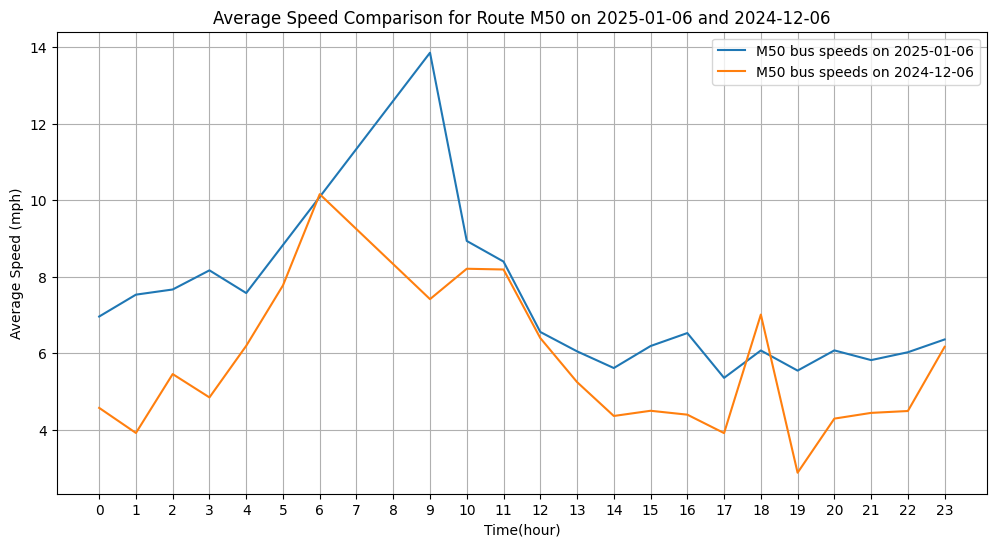

In [37]:
# Group by hour and calculate the average speed for each hour
speeds1["hour"] = speeds1["interpolated_time"].dt.hour
speeds1_avg = speeds1.groupby("hour").agg({"speed_mph": "mean"}).reset_index()

speeds2["hour"] = speeds2["interpolated_time"].dt.hour
speeds2_avg = speeds2.groupby("hour").agg({"speed_mph": "mean"}).reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot for speeds1_avg
plt.plot(speeds1_avg["hour"], speeds1_avg["speed_mph"], label=f"{route_id} bus speeds on {date1}")
# Plot for speeds2_avg
plt.plot(speeds2_avg["hour"], speeds2_avg["speed_mph"], label=f"{route_id} bus speeds on {date2}")

plt.xlabel("Time(hour)")
plt.ylabel("Average Speed (mph)")
plt.title(f"Average Speed Comparison for Route {route_id} on {date1} and {date2}")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24, 1))
plt.show()